In [118]:
import pandas as pd
from sklearn.linear_model import Ridge, BayesianRidge, ElasticNet, RidgeCV, ElasticNetCV, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
#store skater stats csv into dataframe 
game_skater_df = pd.read_csv("data/game_skater_stats.csv")
game_skater_df.head(10)

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,...,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce
0,2016020045,8468513,4,955,1,0,0,2.0,0,0,...,0,1.0,1.0,0,0,1.0,1,858,97,0
1,2016020045,8476906,4,1396,1,0,4,2.0,0,0,...,0,1.0,2.0,0,0,2.0,0,1177,0,219
2,2016020045,8474668,4,915,0,0,1,1.0,0,0,...,0,2.0,0.0,0,0,0.0,-1,805,0,110
3,2016020045,8473512,4,1367,3,0,0,0.0,0,2,...,27,0.0,0.0,0,0,0.0,-1,1083,19,265
4,2016020045,8471762,4,676,0,0,3,2.0,0,0,...,0,0.0,1.0,0,0,0.0,-1,613,63,0
5,2016020045,8478439,4,1008,1,0,2,0.0,0,0,...,0,1.0,0.0,0,0,0.0,-1,911,0,97
6,2016020045,8479648,4,630,0,0,0,2.0,0,0,...,0,0.0,0.0,0,0,0.0,-1,630,0,0
7,2016020045,8470159,4,409,0,0,0,0.0,0,0,...,7,1.0,0.0,0,0,0.0,-1,360,49,0
8,2016020045,8478500,4,1275,0,0,0,1.0,0,0,...,0,0.0,1.0,0,0,0.0,-5,1015,139,121
9,2016020045,8475430,4,1029,0,0,1,5.0,0,0,...,0,0.0,1.0,0,0,1.0,1,988,41,0


In [105]:
#create new dataframe with select columms 
new_game_skater_df = game_skater_df[['game_id', 'player_id', 'team_id', 'timeOnIce', 'assists', 'goals', 'shots', 'blocked', 'powerPlayGoals', 'powerPlayAssists', 'shortHandedGoals', 'shortHandedAssists', ]].copy()
skater_df = new_game_skater_df.drop_duplicates()

#add fantasy points to skater_df
skater_df['fantasy_points'] = (skater_df['assists']*8 + skater_df['goals']*12 + skater_df['shots']*1.6 + skater_df['blocked']*1.6 + skater_df['powerPlayGoals']*0.5 + skater_df['powerPlayAssists']*0.5 + skater_df['shortHandedGoals']*2 + skater_df['shortHandedAssists']*2)
skater_df.fillna(0)
skater_df = skater_df.reset_index(drop=True)
skater_df

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,blocked,powerPlayGoals,powerPlayAssists,shortHandedGoals,shortHandedAssists,fantasy_points
0,2016020045,8468513,4,955,1,0,0,1.0,0,0,0,0,9.6
1,2016020045,8476906,4,1396,1,0,4,2.0,0,0,0,0,17.6
2,2016020045,8474668,4,915,0,0,1,0.0,0,0,0,0,1.6
3,2016020045,8473512,4,1367,3,0,0,0.0,0,2,0,0,25.0
4,2016020045,8471762,4,676,0,0,3,0.0,0,0,0,0,4.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
853399,2018030417,8475807,6,501,0,0,1,0.0,0,0,0,0,1.6
853400,2018030417,8475149,6,1062,0,0,2,0.0,0,0,0,0,3.2
853401,2018030417,8475745,6,913,0,0,2,0.0,0,0,0,0,3.2
853402,2018030417,8478443,6,1006,0,0,1,2.0,0,0,0,0,4.8


In [4]:
#goalie stats csv into dataframe
goalie_stats_df= pd.read_csv('data/game_goalie_stats.csv')
goalie_stats_df.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,pim,shots,saves,powerPlaySaves,shortHandedSaves,evenSaves,shortHandedShotsAgainst,evenShotsAgainst,powerPlayShotsAgainst,decision,savePercentage,powerPlaySavePercentage,evenStrengthSavePercentage
0,2016020045,8473607,4,1504,0,0,0,16,12,1,0,11,0,13,3,NaN,75.000000,33.333333,84.615385
1,2016020045,8473461,4,2011,0,0,0,11,9,1,0,8,0,10,1,L,81.818182,100.000000,80.000000
2,2016020045,8470645,16,3598,0,0,0,27,23,2,0,21,0,23,4,W,85.185185,50.000000,91.304348
3,2017020812,8468011,24,3696,0,0,0,33,30,1,2,27,3,28,2,W,90.909091,50.000000,96.428571
4,2017020812,8475215,7,3539,0,0,0,33,29,4,1,24,1,27,5,L,87.878788,80.000000,88.888889


In [63]:
## select goalie stats df
new_goalie_df = goalie_stats_df[['game_id', 'player_id', 'team_id', 'timeOnIce', 'assists', 'goals', 'shots', 'saves', 'decision']]

#add goals against column
new_goalie_df['goals_against'] = new_goalie_df['shots'] - new_goalie_df['saves']
goalie_df1 = new_goalie_df.drop_duplicates()
goalie_df = goalie_df1.fillna(0)

#add shutout and win columns
goalie_df['shutout'] = np.where((goalie_df['goals_against'] == 0) & (goalie_df['decision']!= 0), 1, 0)
goalie_df['win'] = np.where((goalie_df['decision']== 'W'), 1, 0)


#add fantasy points column to goalie df
goalie_df['fantasy_points'] = (goalie_df['goals']*12 + goalie_df['assists']*8 + goalie_df['saves']*0.8 + goalie_df['shutout']*8 + goalie_df['goals_against']*-4 + goalie_df['win']*12)
goalie_df

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,saves,decision,goals_against,shutout,win,fantasy_points
0,2016020045,8473607,4,1504,0,0,16,12,0,4,0,0,-6.4
1,2016020045,8473461,4,2011,0,0,11,9,L,2,0,0,-0.8
2,2016020045,8470645,16,3598,0,0,27,23,W,4,0,1,14.4
3,2017020812,8468011,24,3696,0,0,33,30,W,3,0,1,24.0
4,2017020812,8475215,7,3539,0,0,33,29,L,4,0,0,7.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56645,2018030415,8471695,6,3522,0,0,21,19,L,2,0,0,7.2
56648,2018030416,8471695,6,3600,0,0,29,28,W,1,0,1,30.4
56649,2018030416,8476412,19,3487,0,0,31,27,L,4,0,0,5.6
56652,2018030417,8476412,19,3600,0,0,33,32,W,1,0,1,33.6


In [21]:
#store player info csv into dataframe 
player_info_df = pd.read_csv('data/player_info.csv')
player_info_df.head()

,player_id,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,birthStateProvince,height,height_cm,weight,shootsCatches
0,8466148,Marian,Hossa,SVK,Stará Lubovna,RW,1979-01-12 00:00:00,NaN,"6' 1""",185.42,207.0,L
1,8465058,Michal,Rozsival,CZE,Vlasim,D,1978-09-03 01:00:00,NaN,"6' 1""",185.42,210.0,R
2,8476906,Shayne,Gostisbehere,USA,Pembroke Pines,D,1993-04-20 01:00:00,FL,"5' 11""",180.34,180.0,L
3,8466285,Brian,Campbell,CAN,Strathroy,D,1979-05-23 01:00:00,ON,"5' 10""",177.80,192.0,L
4,8470607,Brent,Seabrook,CAN,Richmond,D,1985-04-20 01:00:00,BC,"6' 3""",190.50,220.0,R


In [28]:
#store team info csv into dataframe
team_info_df = pd.read_csv('data/team_info.csv')
new_team_df = team_info_df[['team_id', 'shortName']]
new_team_df.head(5)

,team_id,shortName
0,1,New Jersey
1,4,Philadelphia
2,26,Los Angeles
3,14,Tampa Bay
4,6,Boston


In [23]:
#create new dataframe with select columms
new_player_info_df = player_info_df [['player_id', 'firstName', 'lastName', 'nationality']].copy()
new_player_info_df .head()

,player_id,firstName,lastName,nationality
0,8466148,Marian,Hossa,SVK
1,8465058,Michal,Rozsival,CZE
2,8476906,Shayne,Gostisbehere,USA
3,8466285,Brian,Campbell,CAN
4,8470607,Brent,Seabrook,CAN


# Merging dataframes to create a single data set to be used to train machine learning AI

In [27]:
#merging cleaned player info + game skater stats
merge_1_df = new_player_info_df.merge(new_game_skater_df, how='left', left_on='player_id', right_on='player_id')
merge_1_df.head(5)

,player_id,firstName,lastName,nationality,game_id,team_id,timeOnIce,assists,goals,shots,blocked,powerPlayGoals,powerPlayAssists,shortHandedGoals,shortHandedAssists
0,8466148,Marian,Hossa,SVK,2.016020e+09,16.0,723.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0
1,8466148,Marian,Hossa,SVK,2.016020e+09,16.0,1011.0,0.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0
2,8466148,Marian,Hossa,SVK,2.016021e+09,16.0,727.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
3,8466148,Marian,Hossa,SVK,2.016021e+09,16.0,993.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,8466148,Marian,Hossa,SVK,2.015021e+09,16.0,1110.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0


In [29]:
#merging cleaned goalie info + team info
merge_2_df = new_player_info_df.merge(new_goalie_df, how='left', left_on='player_id', right_on='player_id')
merge_2_df


,player_id,firstName,lastName,nationality,game_id,team_id,timeOnIce,assists,goals,shots,saves,decision,goals_against
0,8466148,Marian,Hossa,SVK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8465058,Michal,Rozsival,CZE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8476906,Shayne,Gostisbehere,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8466285,Brian,Campbell,CAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8470607,Brent,Seabrook,CAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60208,8479374,Adam,Mascherin,CAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60209,8479403,Tyler,Parsons,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60210,8480970,Marcus,Hogstrom,SWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60211,8477574,Parker,Milner,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
training_data_df = merge_2_df.merge(merge_1_df, how='left', left_on='player_id', right_on='player_id')
training_data_df

,team_id,franchiseId,shortName,teamName,abbreviation,link,game_id,player_id,timeOnIce_x,assists_x,...,nationality,timeOnIce_y,assists_y,goals_y,shots_y,blocked,powerPlayGoals,powerPlayAssists,shortHandedGoals,shortHandedAssists
0,1,23.0,New Jersey,Devils,NJD,/api/v1/teams/1,2016020107,8476234,3664,0,...,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,23.0,New Jersey,Devils,NJD,/api/v1/teams/1,2015020981,8476234,3600,0,...,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,23.0,New Jersey,Devils,NJD,/api/v1/teams/1,2017020482,8471239,3690,0,...,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,23.0,New Jersey,Devils,NJD,/api/v1/teams/1,2015020453,8471239,3600,0,...,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,23.0,New Jersey,Devils,NJD,/api/v1/teams/1,2017020952,8476234,3600,0,...,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56651,89,NaN,NaN,NaN,NaN,NaN,2019040652,8476945,600,0,...,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56652,89,NaN,NaN,NaN,NaN,NaN,2018040643,8471469,583,0,...,FIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56653,89,NaN,NaN,NaN,NaN,NaN,2018040643,8471227,600,0,...,CAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56654,89,NaN,NaN,NaN,NaN,NaN,2018040643,8471469,583,0,...,FIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
training_data_df.to_csv("training_data.csv")

In [21]:
#creat fantasy points dataframe for skaters
fantasy_skater_data = {'Stats': ['Assists', 'Blocked Shots', 'Goals','Power Play Assists', 'Power Play Goals','Shots on Goal', 'Short Handed Assists', 'Short Handed Goals'], 
                'Points': [8, 1.6, 12, 0.5, 0.5, 1.6, 2, 2 ]}
fantasy_skater_df = pd.DataFrame(fantasy_skater_data)
fantasy_skater_df

,Stats,Points
0,Assists,8.0
1,Blocked Shots,1.6
2,Goals,12.0
3,Power Play Assists,0.5
4,Power Play Goals,0.5
5,Shots on Goal,1.6
6,Short Handed Assists,2.0
7,Short Handed Goals,2.0


In [22]:
T_goalie_data = {'Stats': ['Goals Against', 'Shutouts', 'Saves', 'Wins'],
                      'Points': [-4, 8, 0.8, 12]}
fantasy_goalie_df = pd.DataFrame(fantasy_goalie_data)
fantasy_goalie_df

,Stats,Points
0,Goals Against,-4.0
1,Shutouts,8.0
2,Saves,0.8
3,Wins,12.0


# Machine Learning Model 

### First step is we need to specify what data we want to predict. I beleive we need to use time on ice to predict fantasy points. So we'll use fantasy points as our dependent variable y since it depends on time on ice.

In [106]:
def clean_dataset(skater_df):
    assert isinstance(df, skater_df.DataFrame), "df needs to be a pd.DataFrame"
    skater_df.dropna(inplace=True)
    indices_to_keep = ~skater_df.isin([np.nan, np.inf, -np.inf]).any(1)
    return skater_df[indices_to_keep].astype(np.float64)

In [110]:
pd.isnull(skater_df).sum() > 0

game_id               False
player_id             False
team_id               False
timeOnIce             False
assists               False
goals                 False
shots                 False
blocked                True
powerPlayGoals        False
powerPlayAssists      False
shortHandedGoals      False
shortHandedAssists    False
fantasy_points         True
dtype: bool

In [111]:
skater_df = skater_df.dropna(how='any',axis=0)

In [120]:

x = skater_df['timeOnIce'].values.reshape(-1,1)
y = skater_df['fantasy_points'].values.reshape(-1,1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
regressor = LinearRegression()

#training the algorithm
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

model_df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted' : y_pred.flatten()})
model_df.head()

,Actual,Predicted
0,3.2,10.967906
1,3.2,11.917271
2,6.4,9.969856
3,1.6,10.862421
4,4.8,8.906892


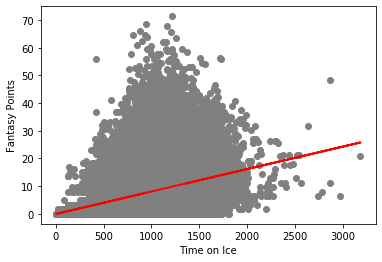

In [123]:
plt.scatter(x_test, y_test, color='gray')
plt.plot(x_test, y_pred, color='red', linewidth=2)
plt.xlabel('Time on Ice')
plt.ylabel('Fantasy Points')
plt.show()